In [1]:
# Importing necessary libraries
!pip install langid
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec, PCA
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, lower, regexp_replace, split, udf
from pyspark.sql.types import StringType, IntegerType 
from pyspark.ml.linalg import Vectors, VectorUDT
import numpy as np
import langid
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from pyspark.ml.linalg import DenseVector, SparseVector
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [2]:
# Create Spark session
spark = SparkSession.builder \
    .config("spark.sql.shuffle.partitions", 10) \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.executor.heartbeatInterval", "100000s") \
    .config("spark.network.timeout", "10000000s") \
    .master("local[*]") \
    .appName("Project 3") \
    .getOrCreate()

## Reading data

In [3]:
# !unzip -u dblp.v10.zip

In [4]:
# from functools import reduce
# file_paths = ["./dblp-ref/dblp-ref-0.json", "./dblp-ref/dblp-ref-1.json", "./dblp-ref/dblp-ref-2.json", "./dblp-ref/dblp-ref-3.json"]
# dfs = [spark.read.json(file_path) for file_path in file_paths]
# df = reduce(lambda df1, df2: df1.union(df2), dfs)
# df.show(5)

# test with single dataset
df = spark.read.json("./dblp-ref/dblp-ref-0.json")

df = df.limit(1000)

## Understanding data

In [5]:
df.printSchema()
total_records = df.count()
# print("Total number of records:", total_records)

df.show(5)
print(f"Number of records: {df.count()}")

root
 |-- abstract: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- n_citation: long (nullable = true)
 |-- references: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- year: long (nullable = true)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|Preliminary Desig...|international con...|2013|
|This paper descri...

In [6]:
df.describe().show()
df.describe().toPandas()
# Check for missing values (excluding `isnan`)
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()
df.select("n_citation").describe().show()
df.filter(df.abstract.isNull() | df.title.isNull()).show()

+-------+-----------------------------+--------------------+-----------------+--------------------+--------------------+-----------------+
|summary|                     abstract|                  id|       n_citation|               title|               venue|             year|
+-------+-----------------------------+--------------------+-----------------+--------------------+--------------------+-----------------+
|  count|                          363|                1000|             1000|                1000|                1000|             1000|
|   mean|                         NULL|                NULL|           20.321|                NULL|                NULL|         2005.855|
| stddev|                         NULL|                NULL|85.92444919794346|                NULL|                NULL|7.519609000441405|
|    min|         A VLSI sorter of ...|00127ee2-cb05-48c...|                0|(alpha, beta) Red...|                    |             1969|
|    max|報告番号: ; 学位授与日: 20.

### Preprocessing

In [7]:
# Filter only English documents
def detect_language(text):
    if text is None:
        return None
    lang, _ = langid.classify(text)
    return lang

# Registering UDF
lang_detect_udf = udf(detect_language, StringType())
df = df.withColumn("language", lang_detect_udf(df.abstract))
df = df.filter(df.language == 'en')
df.show()

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|language|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|Preliminary Desig...|international con...|2013|      en|
|This paper descri...|[Gareth Beale, Gr...|001c58d3-26ad-46b...|        50|[10482dd3-4642-41...|A methodology for...|visual analytics ...|2011|      en|
|This article appl...|[Altaf Hossain, F...|001c8744-73c4-4b0...|        50|[2d84c0f2-e656-4c...|Comparison of GAR...|pattern recogniti...|2009|      en|
|Recent achievemen...|[Ankita Brahmacha...|00a119c4-d367-460...|         0|[84d471

In [8]:
# Lowercase and remove punctuation
df_cleaned = df.withColumn("cleaned_abstract", lower(col("abstract")))
df_cleaned = df_cleaned.withColumn("cleaned_abstract", regexp_replace(col("cleaned_abstract"), r'[!()\-\[\]{};:\'",<>./?@#$%^&*_~]', ''))

In [9]:
# Tokenize the text
tokenizer = Tokenizer(inputCol="cleaned_abstract", outputCol="words")
df_tokenized = tokenizer.transform(df_cleaned)

In [10]:
# Remove stop words
custom_stop_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www']
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=StopWordsRemover().getStopWords() + custom_stop_words)
df_filtered = remover.transform(df_tokenized)

In [11]:
# print(df_filtered.count())

### Vectorization

In [12]:
# Train a Word2Vec model
word2vec = Word2Vec(vectorSize=10, minCount=1, inputCol="filtered_words", outputCol="word2vec_features")
model = word2vec.fit(df_filtered)
df_vectorized = model.transform(df_filtered)

In [13]:
# Selecting features column we use later
df_vectorized = df_vectorized.select("id", "title", "word2vec_features")
titles = [row['title'] for row in df_vectorized.collect()]

In [14]:
# Define UDF for converting sparse to dense vectors
def to_dense(v):
    if isinstance(v, SparseVector):
        return DenseVector(v.toArray())
    elif isinstance(v, DenseVector):
        return v
    else:
        raise TypeError("Unsupported vector type")

to_dense_udf = udf(to_dense, VectorUDT())
# Apply UDF to convert features to dense vectors and extract feature column
df_dense = df_vectorized.withColumn('dense_features', to_dense_udf(col('word2vec_features')))
df_dense = df_dense.select("id", "title", "dense_features")
# Convert the Spark DataFrame to Pandas DataFrame
df_dense_pd = df_dense.toPandas()
# print(df_dense_pd)
features = np.array(df_dense_pd['dense_features'].tolist())

similarity_matrix = cosine_similarity(features)

### Clustering

In [15]:
# Standardize the data for PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
# print(scaled_data)
# Apply PCA to reduce dimensions while keeping 95% of the variance
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(scaled_data)
# print(reduced_data)

## Ploting 

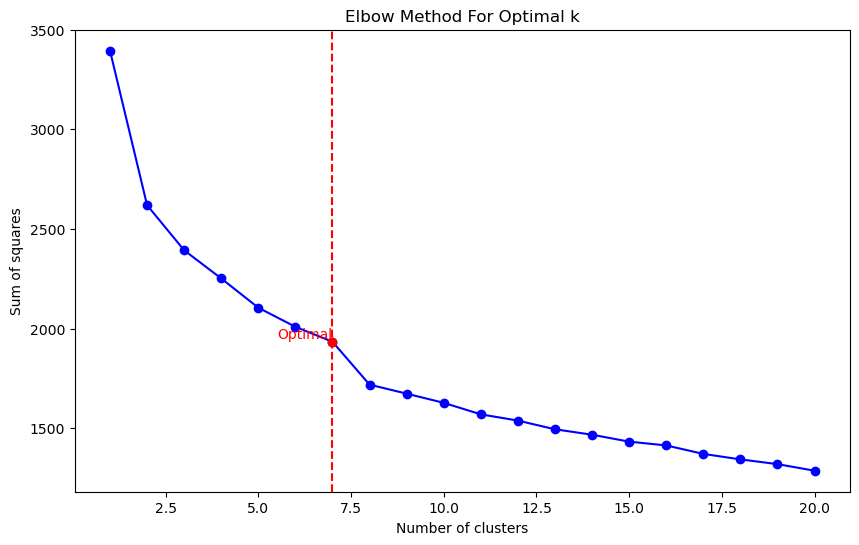

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(reduced_data)
    wcss.append(kmeans.inertia_)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss, 'bo-')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squares')

# Finding the elbow point
def find_elbow(wcss):
    differences = np.diff(wcss)
    second_differences = np.diff(differences)
    optimal_index = np.argmin(second_differences) + 2
    return optimal_index

optimal_k = find_elbow(wcss)
plt.axvline(x=optimal_k, color='r', linestyle='--')
plt.plot(optimal_k, wcss[optimal_k-1], 'ro')
plt.text(optimal_k, wcss[optimal_k-1], 'Optimal', horizontalalignment='right', verticalalignment='bottom', color='r')
# plt.show()

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(reduced_data)
df_dense_pd['Cluster'] = clusters
# print(df_dense_pd.head())


## Recommendation 

In [17]:
def cosine_sim(a, b):
    return cosine_similarity(a, b)

def vectorize_title(title, model):
    words = title.split()  # simple tokenization, improve as needed
    vectors = []
    for word in words:
        vector = model.getVectors().filter(col("word") == word).select("vector").collect()
        if vector:
            vectors.append(vector[0][0])
    if vectors:
        mean_vector = np.mean(vectors, axis=0)
        return mean_vector
    else:
        return np.zeros(model.getVectorSize())

In [18]:
def recommend_papers(title, model, df_dense_pd, top_n=5):
    input_vector = vectorize_title(title, model).reshape(1, -1)
    features = np.array(df_dense_pd['dense_features'].tolist())
    similarities = cosine_sim(input_vector, features)[0]
    top_indices = similarities.argsort()[-top_n:][::-1]
    recommendations = df_dense_pd.iloc[top_indices].copy()
    recommendations.loc[:, 'similarity'] = similarities[top_indices]
    return recommendations[['title', 'similarity']]

# Example usage
title = "Deep learning for image classification"
recommended_papers = recommend_papers(title, model, df_dense_pd, top_n=5)
print(recommended_papers)


                                                 title  similarity
158  Key requirements for integrating usability eng...    0.962574
208  Spreadsheets on the Move: An Evaluation of Mob...    0.961905
59   Soft Systems Methodology for Hard Systems Engi...    0.959269
343  Formulation of hierarchical task network servi...    0.953947
153  Annotation for the Semantic Web During Website...    0.953753


End